# 完整代码（在测试集上评估模型精度）


>
1. 图像分类预测结果

2. 测试集整体准确率

3. top-n准确率

4. 分类报告

5. 各类别准确率（recall）

6. 混淆矩阵

7. PR曲线

8. ROC曲线

9. 评估指标可视化



2024/5/6


In [5]:
%pip install scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple
%pip install seaborn -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simpleNote: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
     --------------------------------------- 0.1/10.6 MB 656.4 kB/s eta 0:00:17
     --------------------------------------- 0.1/10.6 MB 656.4 kB/s eta 0:00:17
     --------------------------------------- 0.1/10.6 MB 476.3 kB/s eta 0:00:23
     --------------------------------------- 0.1/10.6 MB 476.3 kB/s eta 0:00:23
      -------------------------------------- 0.2/10.6 MB 615.9 kB/s eta 0:00:17
      -------------------------------------- 0.2/10.6 MB 654.9 kB/s eta 0:00:16
      -------------------------------------- 0.3/10.6 MB 682.7 kB/s eta 0:00:16
     - ------------------------------------- 0.3/10.6 MB 630.9 kB/s eta 0:00:17
     - ------------------------------------- 0.3/10.6 MB 633.4 kB/s eta 0:00:17
     - --

## 设置中文字体

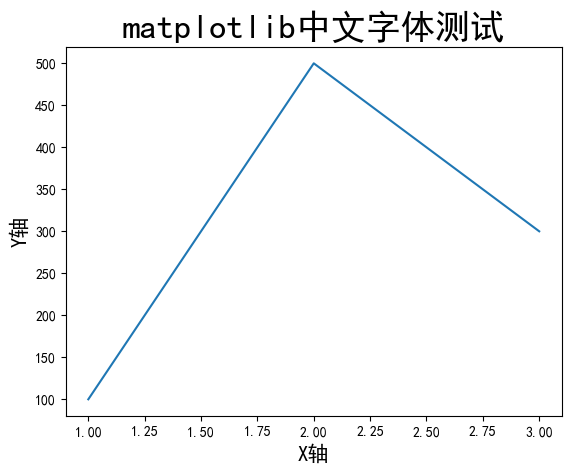

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# # windows操作系统
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

plt.plot([1,2,3], [100,500,300])
plt.title('matplotlib中文字体测试', fontsize=25)
plt.xlabel('X轴', fontsize=15)
plt.ylabel('Y轴', fontsize=15)
plt.show()

## 在kaggle上的运行代码

In [ ]:
# -*- coding: utf-8 -*-
#  所有模型的测试集预测
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
import timm
from torch import nn
from d2l import torch as d2l
import re
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from efficientnet_pytorch import EfficientNet  
from sklearn.model_selection import KFold
from torchvision.models import resnet101, resnet152, resnet18, resnet34, resnet50,mobilenet,mobilenet_v2,mobilenet_v3_large, mobilenet_v3_small, mobilenetv2, mobilenetv3
import cv2
from sklearn.metrics import precision_recall_curve,average_precision_score,classification_report,confusion_matrix,roc_curve,auc
#概率分布预测
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import itertools
from matplotlib import colors as mcolors
import random


class FineTuneModel:
    """
    管理预训练模型：
    1. EfficientNet系列模型  
    2. InceptionNet系列模型
    3. ResNet系列模型
    4. MobileNet系列模型

    """
    def __init__(self, devices, num_classes,model_name):
        self.devices = devices
        self.num_classes = num_classes
        self.model_name = model_name

    def get_efficientnet(self):
        """
        微调EfficientNet模型。
        :param model_name: EfficientNet模型的版本，如'efficientnet-b0'到'efficientnet-b7'。
        :return: 微调后的模型。
        """
        # 加载预训练的EfficientNet模型
        finetune_net = EfficientNet.from_pretrained(self.model_name)
        # 替换输出层
        num_ftrs = finetune_net._fc.in_features
        finetune_net._fc = nn.Linear(num_ftrs, self.num_classes)
        # 将模型参数分配到设备上
        finetune_net = finetune_net.to(self.devices)
        # 冻结所有层（除了最后的全连接层）
        for name, param in finetune_net.named_parameters():
            if 'fc' not in name:  # 不冻结全连接层
                param.requires_grad = False
        # 确保全连接层的参数可训练
        for param in finetune_net._fc.parameters():
            param.requires_grad = True
        return finetune_net

    def get_mobilenet(self):
        """
        加载预训练的MobileNet模型并进行微调设置。
        'mobilenet',
        'mobilenet_v2',
        'mobilenet_v3_large', 
        'mobilenet_v3_small', 
        'mobilenetv2', 
        'mobilenetv3',
        """
        # 加载预训练的MobileNetV2模型
        base_model_func = getattr(torchvision.models, self.model_name)
        base_model = base_model_func(pretrained=True)
        if self.model_name == "mobilenet_v2":
            num_features = base_model.classifier[-1].in_features
            # 定义一个新的分类头
            classifier = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, self.num_classes)
            )
            # 替换原有的分类头
            base_model.classifier = classifier
        else:
                 # 获取最后一个卷积层的输出通道数量
            num_features = base_model.features[-1].out_channels
            # 定义一个新的分类头
            classifier = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, self.num_classes)
            )
            # 替换原有的分类头
            base_model.classifier = classifier
        # 将模型参数分配到指定设备
        base_model = base_model.to(self.devices)
        # 冻结特征提取器的参数
        for name, param in base_model.named_parameters():
            if 'classifier' not in name:  # 确保只冻结特征提取部分的参数
                param.requires_grad = False
        return base_model
    
    
    def get_resnet(self):
        #加载预训练的resnet模型
        """
        resnet101, 
        resnet152, 
        resnet18, 
        resnet34, 
        resnet50
        """
        # 从torchvision.models模块中动态获取模型
        base_model_func = getattr(torchvision.models, self.model_name)
        base_model = base_model_func(pretrained=True)
        num_features = base_model.fc.in_features
        # 定义一个新的分类头
        classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256,self.num_classes)
        )
        # 替换原有的全连接层（分类头）
        base_model.fc = classifier
        # 将模型参数分配到指定设备
        base_model = base_model.to(self.devices)
        # 冻结特征提取器的参数
        for name, param in base_model.named_parameters():
            if 'fc' not in name:  # 确保只冻结特征提取部分的参数
                param.requires_grad = False

        return base_model


 #微调预训练模型
def get_net(devices,num_classes,model_name,model_leibie):
        fine_tune_model = FineTuneModel(devices=devices, num_classes=num_classes,model_name = model_name)  # 使用微调模型
        if model_leibie == 'get_efficientnet':
            base_model = fine_tune_model.get_efficientnet()
        elif model_leibie == 'get_mobilenet':
            base_model = fine_tune_model.get_mobilenet()
        elif model_leibie == 'get_resnet':
            base_model = fine_tune_model.get_resnet()
        return base_model


def predict_(img,num_classes,model_name,model_weight_pth,classes,model_leibie,model_path_zheng,is_zheng=True):
    """
    img: #测试图片路径
    num_classes : #类别数量：11、6、3（因为加了一个未知类别）
    model_name ： #模型名称
    model_weight_pth : #待读取的模型权重的保存路径
    classes： #索引与标签的字典
    model_leibie: #模型类别
    model_path_zheng: #整体模型路径
    is_zheng: #是否整体模型
    """
    #定义了数据转换的操作。通过transforms.ToTensor()将图像转换为张量，transforms.Normalize()对图像进行归一化处理
    data_transform = transforms.Compose([
         transforms.Resize(256),
         # 从图像中心裁切224x224大小的图片
         transforms.CenterCrop(224),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
    ])
    # 有 GPU就用 GPU，没有就用 CPU
    devices = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    if img.mode == 'RGBA':  #如果图像是RGBA模式，就将其转换为RGB模式
        img = img.convert('RGB')
    img = data_transform(img) #将输入图像应用数据转换操作
    img = torch.unsqueeze(img, dim=0) #在第0维度上添加一个维度，用于适配网络输入
    img = img.to(devices)   # 将张量移动到GPU上  
    if is_zheng:
        model = torch.load(model_path_zheng)  #直接加载整个模型
    else:
        model = get_net(devices,num_classes,model_name,model_leibie)   #实例化的image_classifier
        model.load_state_dict(torch.load(model_weight_pth)) #指定了模型权重文件路径，并加载权重到模型中
    model.eval() #将模型设置为评估模式，即关闭Dropout和Batch Normalization的随机性
    #将输入图像输入模型中进行推理
    with torch.no_grad():
        output = torch.squeeze(model(img))
        predict = torch.softmax(output, dim=0)
    # 获取每个类别的预测概率
    class_probs = {str(i): round(prob.item(), 5) for i, prob in enumerate(predict)}
    predict_cla = torch.argmax(predict).cpu().numpy()
    max_prob = round(predict[predict_cla].item(), 5)
    predicted_class = classes[str(predict_cla)]
    return predicted_class, max_prob, class_probs



#测试集预测结果、各类别准确率评估指标
def predict_acc_all(labels_path,image_dir,num_classes,model_name,model_weight_pth,classes,model_leibie,model_path_zheng,is_zheng=True):
    #计算在测试集上的准确率
        labels_df = pd.read_csv(labels_path)  #假设labels.csv的格式是：ID,labels
        true_labels = {row['ID']: row['labels'] for _, row in labels_df.iterrows()}  # 创建一个字典来存储真实标签
        img_path_lt = [] #图片路径
        predicted_class_topn_lt = [] #top_n预测类别
        top_n = []  # 初始化 top_n 列表
        true_class_lt = [] #真实类别
        class_probs_list = [] #每个类型的置信度
        correct_count = 0  # 初始化计数器
        total_count = 0
        photo_count = 0 #初始化图片计数器
        import time
        start_time = time.time()  # 开始计时
        # 遍历未知图片目录
    #     image_dir = r"/kaggle/working/my_directory_shi/train_valid_test/test/unknown/"
        for filename in os.listdir(image_dir):
            if filename.endswith(".png"):  # 根据你的图片文件类型调整
                photo_count += 1 #图片个数统计
                base_name = filename.split('.')[0]   # 移除文件名的后缀以匹配labels.csv中的ID
                img_path = os.path.join(image_dir, filename)
                img_path_lt.append(img_path)  #存储图片的路径
                predicted_class, max_prob,class_probs = predict_(Image.open(img_path),num_classes,model_name,model_weight_pth,classes,model_leibie,model_path_zheng,is_zheng) # 预测
                class_probs_list.append(class_probs)
                # 对 class_probs 字典进行排序，返回一个列表，列表的每个元素是一个元组，元组的第一个元素是键，第二个元素是值
                sorted_class_probs = sorted(class_probs.items(), key=lambda x: x[1], reverse=True)
                # 取前三个元素
                top3_class_probs = sorted_class_probs[:3]
#                 print(top3_class_probs)
                # 将 top3_class_probs 添加到 predicted_class_topn_lt 列表中
                predicted_class_topn_lt.append(top3_class_probs)
                
                true_class = true_labels.get(int(base_name), None)  # 获取真实类别，这里使用去除后缀的base_name来查找
                true_class_lt.append(true_class)
#                 检查 top3_class_probs 是否包含真实类别
                if true_class in [classes[str(item[0])] for item in top3_class_probs]:
                    top_n.append(1)
                else:
                    top_n.append(0)
#                 print(top_n)
#                 print(f'真实：{true_class}',f"预测：{predicted_class}",f"最大概率：{max_prob}",f"所有概率:{class_probs}")
                if true_class is None:
                    print(f"警告：找不到ID为{base_name}在labels.csv中的标签，跳过此文件。")
                    continue
                if str(predicted_class) == true_class:   # 更新计数器
                    correct_count += 1
                total_count += 1

        end_time = time.time()  # 结束计时
        total_time = end_time - start_time  # 总处理时间
        print(f"总耗时: {total_time:.2f}秒")
        print(f"测试集图片数: {photo_count}张")
        print(f"每张图片耗时photo_time：{(total_time/photo_count):2f}秒")
        
        # 创建一个字典，其中键是列名，值是数据
        data = {
            'img_path': img_path_lt,
            'true_class': true_class_lt,
            'top_n预测正确': top_n
        }
        
        # 使用循环来添加 top-n 预测类别和置信度的列
        for i in range(3):
            data[f'top-{i+1}-predicted-class'] = [classes[str(item[i][0])] for item in predicted_class_topn_lt]
            data[f'top-{i+1}-probs'] = [item[i][1] for item in predicted_class_topn_lt]

        # 将每个类别的置信度添加到数据字典中
        for i in range(num_classes):
            i_c = classes[str(i)]
            data[f'class_{i_c}_prob'] = [class_probs[str(i)] for class_probs in class_probs_list]
        # 创建 DataFrame
        df = pd.DataFrame(data)
        # 保存为 csv 文件
        df.to_csv('测试集预测结果.csv', index=False)
        # print(df)
        # 计算准确率
        accuracy = correct_count / total_count if total_count > 0 else 0
        print("==============================================")
        print(f"预测准确率test_acc：{accuracy * 100:.2f}%")
        # 计算 top_n 预测正确的概率
        top_n_accuracy = (sum(df['top_n预测正确']) / len(df['top_n预测正确'])) * 100
        print(f"top_n 预测正确的概率是 {top_n_accuracy:.2f}%")
        print("=======================================")
        print("分类报告与各类别准确率")
        print(classification_report(df['true_class'], df['top-1-predicted-class'], target_names=classes.values()))
        report = classification_report(df['true_class'], df['top-1-predicted-class'], target_names=classes.values(), output_dict=True)
        del report['accuracy']
        df_report = pd.DataFrame(report).transpose()
        # print(df_report)
        #各类别准确率
        accuracy_list = []
        for sanye in tqdm(classes.values()):
            df_temp = df[df['true_class']==sanye]
            accuracy = sum(df_temp['true_class'] == df_temp['top-1-predicted-class']) / len(df_temp)
            accuracy_list.append(accuracy)
        # 计算 宏平均准确率 和 加权平均准确率
        acc_macro = np.mean(accuracy_list)
        acc_weighted = sum(accuracy_list * df_report.iloc[:-2]['support'] / len(df))
        accuracy_list.append(acc_macro)
        accuracy_list.append(acc_weighted)
        df_report['accuracy'] = accuracy_list
        print(df_report)
        df_report.to_csv('各类别准确率评估指标.csv', index_label='类别')


#混淆矩阵
def cnf_matrix_plotter(classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    df = pd.read_csv('测试集预测结果.csv')
    cm = confusion_matrix(df['true_class'], df['top-1-predicted-class'])
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    plt.title('混淆矩阵', fontsize=30)
    plt.xlabel('预测类别', fontsize=25, c='r')
    plt.ylabel('真实类别', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()
    # 查看所有配色方案
    # dir(plt.cm)
    return cm
# df = pd.read_csv('测试集预测结果.csv', encoding='utf-8')
# cnf_matrix_plotter(df, classes, cmap='Blues')



#筛选出测试集中，真实为A类，但被误判为B类的图像
def get_wrong_predict(true_A,pred_B,is_plt=True):
    df = pd.read_csv('测试集预测结果.csv')
    wrong_df = df[(df['true_class']==true_A)&(df['top-1-predicted-class']==pred_B)]
    #可视化上表中所有被误判的图像
    if is_plt:
        for idx, row in wrong_df.iterrows():
            img_path = row['img_path']
            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                print(f"无法读取图像：{img_path}")
            else:
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                title_str = img_path + '\nTrue:' + row['true_class'] + ' Pred:' + row['top-1-predicted-class']
                plt.title(title_str)
                plt.show()
    else:
        return wrong_df
# df = pd.read_csv('测试集预测结果.csv')
# wrong_df = get_wrong_predict(df,'YNKM','SXXA',is_plt=True)


#PR曲线
def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
    markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    linestyle = ['--', '-.', '-']
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

#PR曲线
def plot_PR_curve():
    plt.figure(figsize=(14, 10))
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    # plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='随机模型')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.rcParams['font.size'] = 22
    plt.grid(True)
    df = pd.read_csv("测试集预测结果.csv")
    ap_list = []
    for each_class in idx_to_labels.values():
        y_test = list((df['true_class'] == each_class))
        y_score = list(df['class_{}_prob'.format(each_class)])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        AP = average_precision_score(y_test, y_score, average='weighted')
        plt.plot(recall, precision, **get_line_arg(), label=each_class)
        plt.legend()
        ap_list.append(AP)
    plt.legend(loc='best', fontsize=12)
    plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
    plt.show()
    df_report = pd.read_csv('各类别准确率评估指标.csv')
    # 计算 AP值 的 宏平均 和 加权平均
    macro_avg_auc = np.mean(ap_list)
    weighted_avg_auc = sum(ap_list * df_report.iloc[:-2]['support'] / len(df))
    ap_list.append(macro_avg_auc)
    ap_list.append(weighted_avg_auc)
    df_report['AP'] = ap_list
    # print(df_report)
    df_report.to_csv('各类别准确率评估指标.csv', index=False)


#ROC曲线
def plot_roc_curve():
    plt.figure(figsize=(14, 10))
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='随机模型')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.rcParams['font.size'] = 22
    plt.grid(True)
    df = pd.read_csv('测试集预测结果.csv')
    auc_list = []
    for each_class in idx_to_labels.values():
        y_test = list((df['true_class'] == each_class))
        y_score = list(df['class_{}_prob'.format(each_class)])
        fpr, tpr, threshold = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, **get_line_arg(), label=each_class)
        plt.legend()
        auc_list.append(auc(fpr, tpr))

    plt.legend(loc='best', fontsize=12)
    plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
    plt.show()
    df_report = pd.read_csv('各类别准确率评估指标.csv')
    # 计算 AUC值 的 宏平均 和 加权平均
    macro_avg_auc = np.mean(auc_list)
    weighted_avg_auc = sum(auc_list * df_report.iloc[:-2]['support'] / len(df))
    auc_list.append(macro_avg_auc)
    auc_list.append(weighted_avg_auc)
    df_report['AUC'] = auc_list
    # print(df_report)
    df_report.to_csv('各类别准确率评估指标.csv', index=False)


#绘制各类别评估指标柱状图
def plot_bar_chart(feature):
    """
    绘制各类别评估指标柱状图
    :param df: DataFrame
    :param feature: str
    # feature = 'precision'
    # feature = 'recall'
    # feature = 'f1-score'
    # feature = 'accuracy'
    # feature = 'AP'
    # feature = 'AUC'
    :return:
    """
    df = pd.read_csv('各类别准确率评估指标.csv')
    df_plot = df.sort_values(by=feature, ascending=False)
    plt.figure(figsize=(22, 7))
    x = df_plot['类别']
    y = df_plot[feature]
    ax = plt.bar(x, y, width=0.6, facecolor='#1f77b4', edgecolor='k')
    plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
    plt.xticks(rotation=45)
    plt.tick_params(labelsize=15)
    # plt.xlabel('类别', fontsize=20)
    plt.ylabel(feature, fontsize=20)
    plt.title('评估指标 {}'.format(feature), fontsize=25)
    plt.savefig('各类别评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_inches='tight')
    plt.show()
# plot_bar_chart('AUC')







if __name__ == '__main__':
    # # 根据 labels.csv 载入类别和对应 ID
    # idx_to_labels = pd.read_csv("D:\SanYeQing_Project\wht-sanyeqing\idx_to_labels.csv",encoding='utf-8')
    # # 创建一个字典来存储真实标签
    # idx_to_labels = {str(index): row['labels'] for index, row in idx_to_labels.iterrows()}  
    random.seed(124)
    
    #根据json文件获取类别
#     import json
#     class_json_path = '/kaggle/input/sanyeqing/class_5.json'
#     json_file = open(class_json_path, 'rb')
#     idx_to_labels = json.load(json_file)
   
    #直接将json文件中类别、标签字典复制过来
    idx_to_labels = {
   "0":"云南省",
   "1":"广西省",
   "2":"未知",
   "3":"浙江省",
   "4":"贵州省",
   "5":"陕西省"
}
    print(idx_to_labels)
    #测试集预测结果、各类别准确率评估指标
    predict_acc_all(labels_path="/kaggle/input/sanyeqing/labels_hun_5_weizhi.csv",
                        image_dir="/kaggle/working/my_directory_shi/train_valid_test/test/unknown/",
                        num_classes=6,
                        model_name='resnet152',
                        model_weight_pth="/kaggle/working/model_wht_wu.pth",
                        classes=idx_to_labels,
                        model_leibie = "get_resnet",
                        model_path_zheng="/kaggle/working/model_wht_wu_zheng.pth",
                        is_zheng=True)
    #混淆矩阵
    cnf_matrix_plotter(classes=idx_to_labels, cmap='Blues')
    #PR曲线
    plot_PR_curve()
    #ROC曲线
    plot_roc_curve()
    #绘制各类别评估指标柱状图
    plot_bar_chart('AUC')
    #筛选出测试集中，真实为A类，但被误判为B类的图像
    get_wrong_predict(true_A="广西省",pred_B="陕西省",is_plt=True)
    print(get_wrong_predict(true_A="广西省",pred_B="陕西省",is_plt=False))

    

    
    #单张图片的预测概率 (可选看)
    from PIL import ImageDraw
    def show_image(img, title=None):
        """展示图像"""
        plt.imshow(img)
        if title:
            plt.title(title)
        #  plt.axis('off')  # 不显示坐标轴
        plt.show()
    # 在predict_函数调用之后，添加如下代码来显示图像 
    img = Image.open(r"/kaggle/working/my_directory_wu/train_valid_test/test/unknown/3796.png")
    predicted_class ,max_prob,sorted_class_probs= predict_(img, num_classes=6,
                        model_name='resnet152',
                        model_weight_pth="/kaggle/working/model_wht_wu.pth",
                        classes=idx_to_labels,
                        model_leibie = "get_resnet",
                        model_path_zheng="/kaggle/working/model_wht_wu_zheng.pth",
                        is_zheng=True
                                            )
    # 创建一个 ImageDraw 对象
    draw = ImageDraw.Draw(img)
    # 定义起始位置
    start_x = 10
    start_y = 10
    # 定义行间距
    line_spacing = 15
    # 将字典转换为列表
    sorted_class_probs_list = list(sorted_class_probs.items())

    # 遍历字典，将键和值添加到图像上
    for key, value in sorted_class_probs_list[:5]:
        key = idx_to_labels[str(key)]
        text = f"{key}:       {value}"
        draw.text((start_x, start_y), text, fill=(255, 0, 0, 1))
        start_y += line_spacing  # 更新y坐标，以便下一行文本在新的一行
    # 显示图像
    show_image(img)  
    print(f"最可能的类别：{predicted_class}")
    print(f"最大分类概率：{max_prob}")
    print(sorted_class_probs)
    

## 本地修改后的代码


{'0': '云南省', '1': '广西省', '2': '未知', '3': '浙江省', '4': '贵州省', '5': '陕西省'}
总耗时: 180.88秒
测试集图片数: 1842张
每张图片耗时photo_time：0.098200秒
预测准确率test_acc：97.18%
top_n 预测正确的概率是 99.84%
分类报告与各类别准确率
              precision    recall  f1-score   support

         云南省       0.98      0.97      0.97       296
         广西省       0.95      0.97      0.96       339
          未知       1.00      1.00      1.00       310
         浙江省       0.99      0.96      0.98       293
         贵州省       0.97      0.97      0.97       308
         陕西省       0.95      0.96      0.95       296

    accuracy                           0.97      1842
   macro avg       0.97      0.97      0.97      1842
weighted avg       0.97      0.97      0.97      1842



100%|██████████| 6/6 [00:00<00:00, 570.30it/s]

              precision    recall  f1-score  support  accuracy
云南省            0.976190  0.969595  0.972881    296.0  0.969595
广西省            0.945402  0.970501  0.957787    339.0  0.970501
未知             1.000000  1.000000  1.000000    310.0  1.000000
浙江省            0.989474  0.962457  0.975779    293.0  0.962457
贵州省            0.973856  0.967532  0.970684    308.0  0.967532
陕西省            0.949833  0.959459  0.954622    296.0  0.959459
macro avg      0.972459  0.971591  0.971959   1842.0  0.971591
weighted avg   0.972018  0.971770  0.971827   1842.0  0.971770


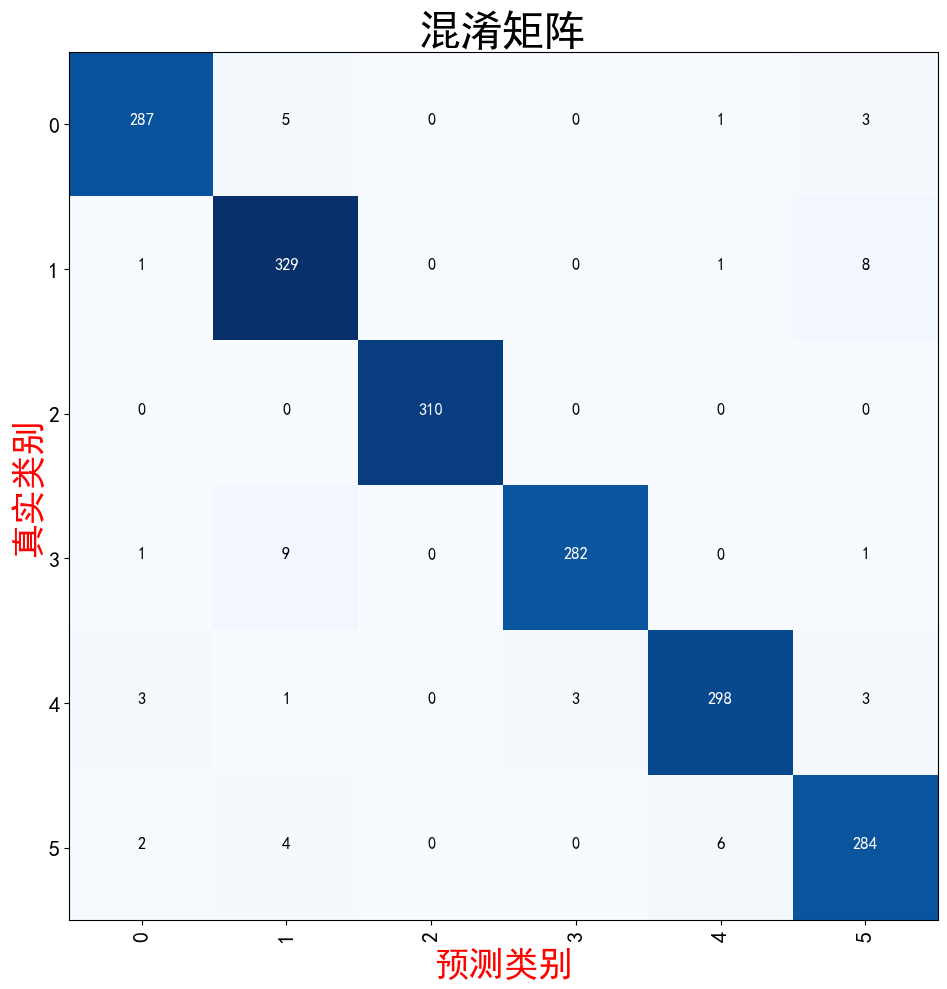

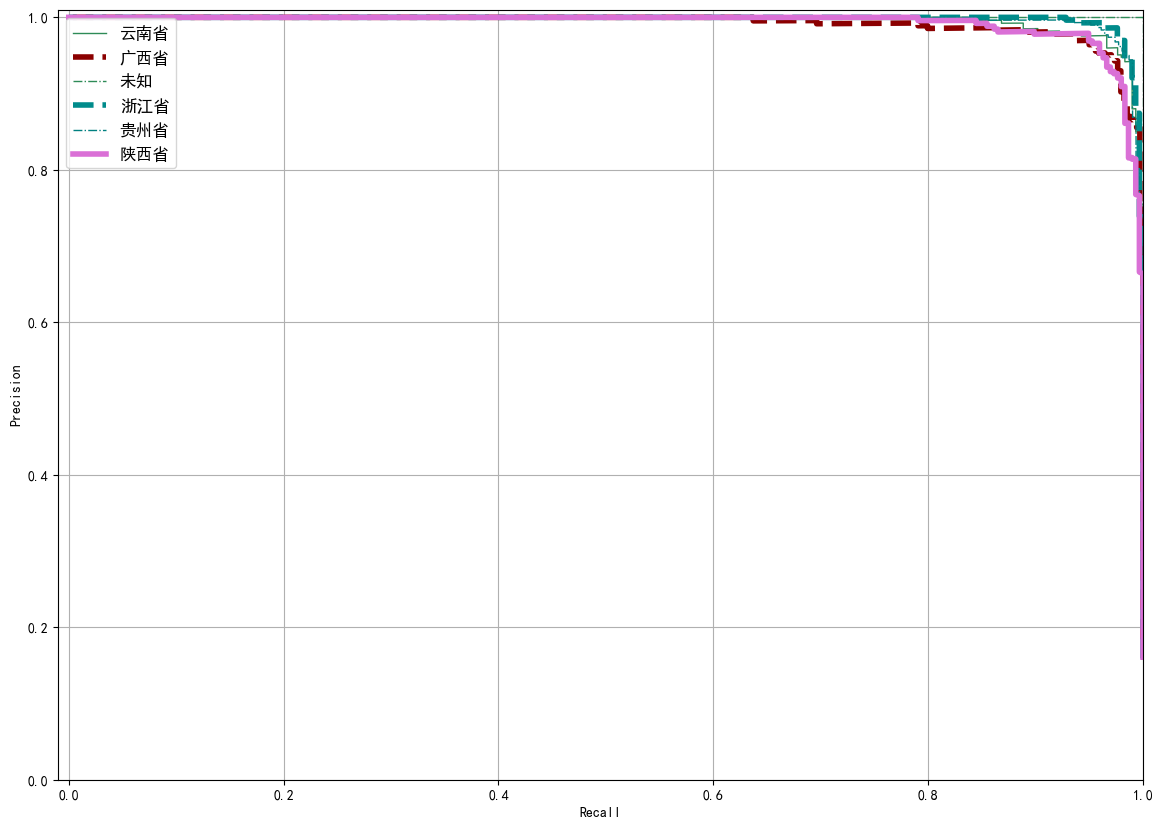

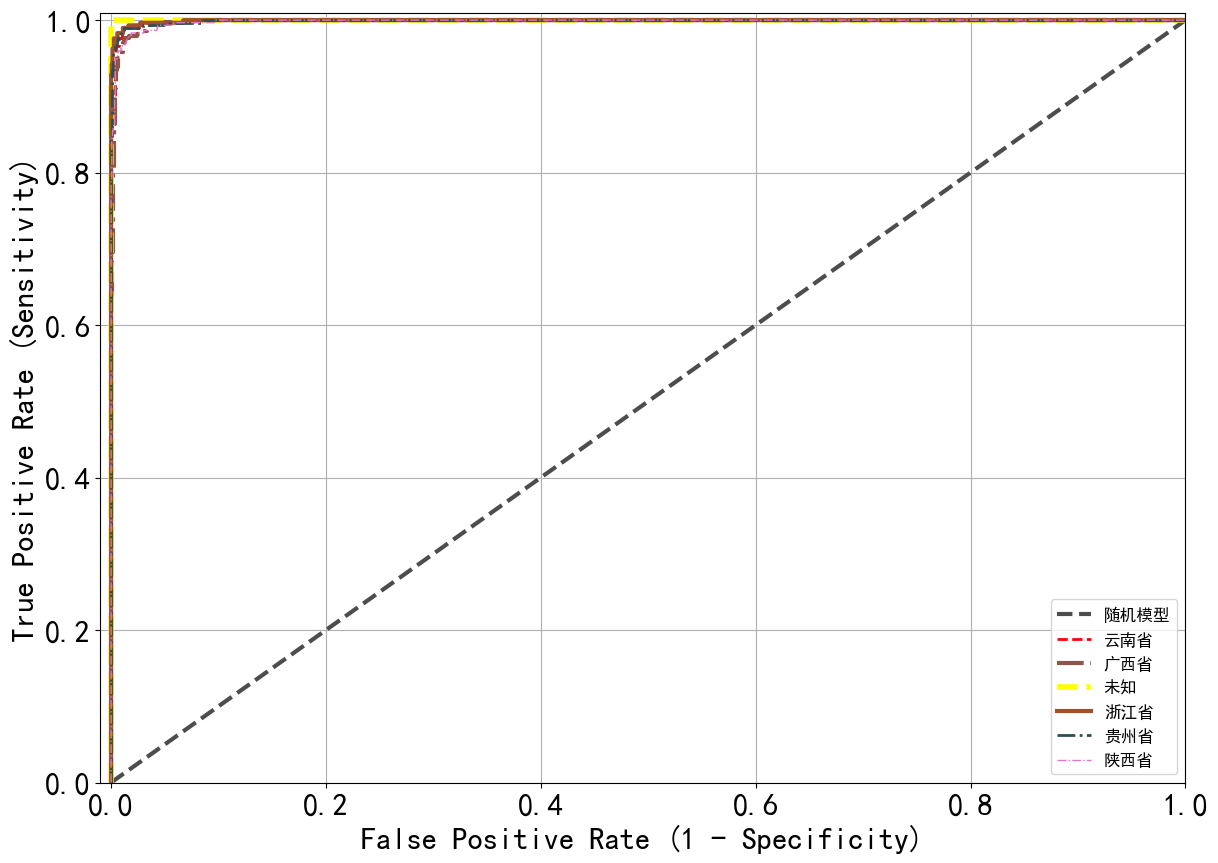

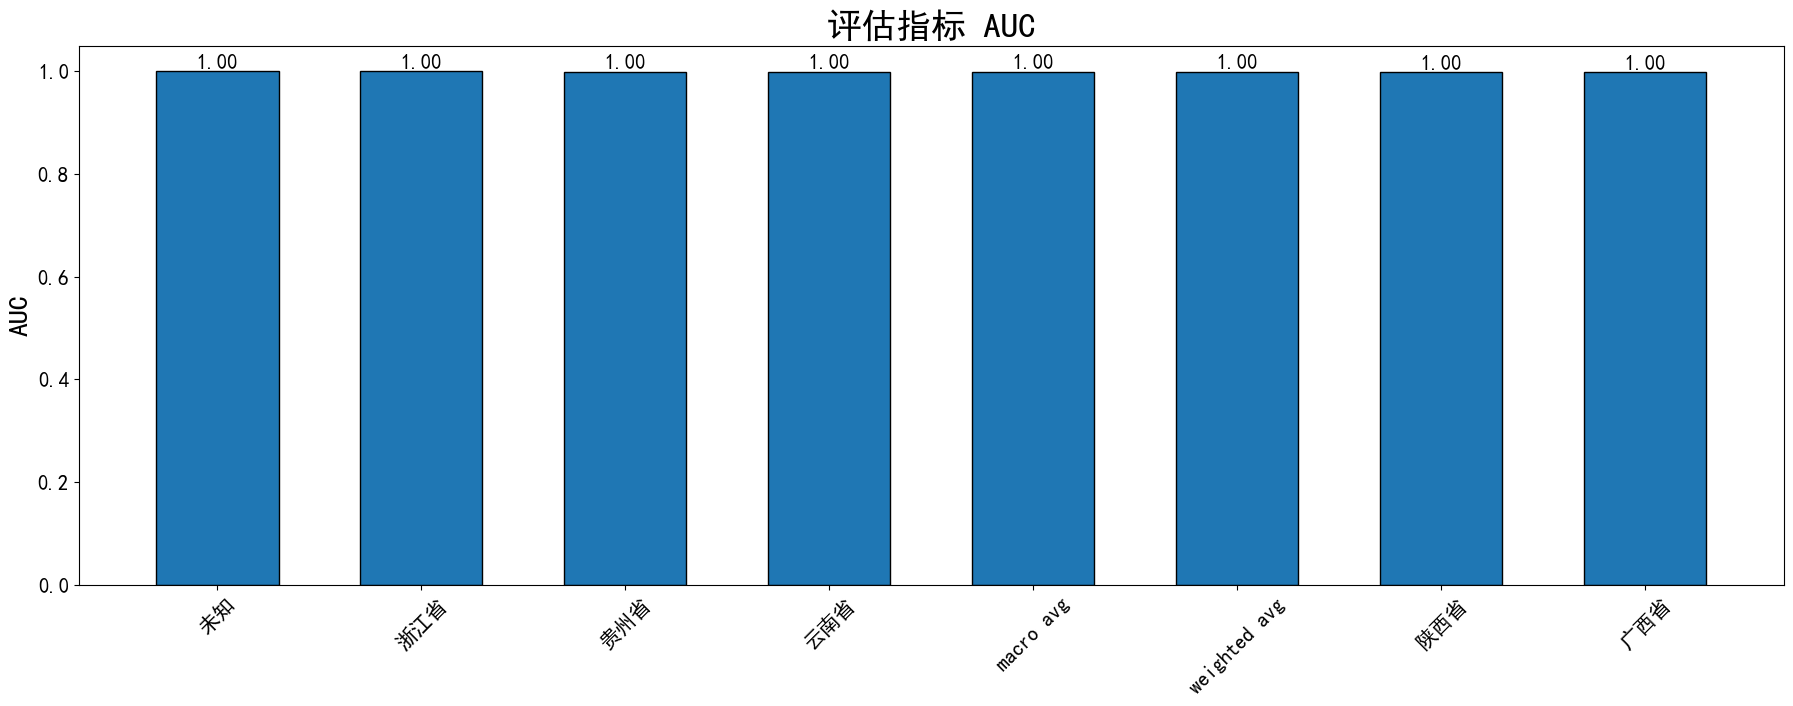

Empty DataFrame
Columns: [img_path, true_class, top_n预测正确, top-1-predicted-class, top-1-probs, top-2-predicted-class, top-2-probs, top-3-predicted-class, top-3-probs, class_云南省_prob, class_广西省_prob, class_未知_prob, class_浙江省_prob, class_贵州省_prob, class_陕西省_prob]
Index: []
路径存在


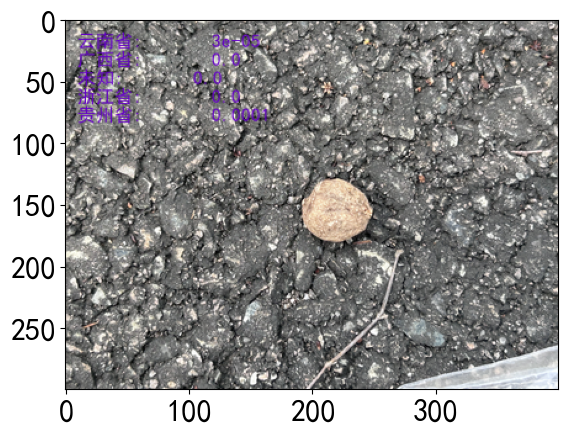

最可能的类别：陕西省
最大分类概率：0.99987
{'0': 3e-05, '1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0001, '5': 0.99987}


In [17]:
# -*- coding: utf-8 -*-
#  所有模型的训练
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
import timm
from torch import nn
from d2l import torch as d2l
import re
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from efficientnet_pytorch import EfficientNet  
from sklearn.model_selection import KFold
from torchvision.models import resnet101, resnet152, resnet18, resnet34, resnet50,mobilenet,mobilenet_v2,mobilenet_v3_large, mobilenet_v3_small, mobilenetv2, mobilenetv3
import cv2
from sklearn.metrics import precision_recall_curve,average_precision_score,classification_report,confusion_matrix,roc_curve,auc
#概率分布预测
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import itertools
from matplotlib import colors as mcolors
import random


class FineTuneModel:
    """
    管理预训练模型：
    1. EfficientNet系列模型  
    2. InceptionNet系列模型
    3. ResNet系列模型
    4. MobileNet系列模型

    """
    def __init__(self, devices, num_classes,model_name):
        self.devices = devices
        self.num_classes = num_classes
        self.model_name = model_name

    def get_efficientnet(self):
        """
        微调EfficientNet模型。
        :param model_name: EfficientNet模型的版本，如'efficientnet-b0'到'efficientnet-b7'。
        :return: 微调后的模型。
        """
        # 加载预训练的EfficientNet模型
        finetune_net = EfficientNet.from_pretrained(self.model_name)
        # 替换输出层
        num_ftrs = finetune_net._fc.in_features
        finetune_net._fc = nn.Linear(num_ftrs, self.num_classes)
        # 将模型参数分配到设备上
        finetune_net = finetune_net.to(self.devices)
        # 冻结所有层（除了最后的全连接层）
        for name, param in finetune_net.named_parameters():
            if 'fc' not in name:  # 不冻结全连接层
                param.requires_grad = False
        # 确保全连接层的参数可训练
        for param in finetune_net._fc.parameters():
            param.requires_grad = True
        return finetune_net

    def get_mobilenet(self):
        """
        加载预训练的MobileNet模型并进行微调设置。
        'mobilenet',
        'mobilenet_v2',
        'mobilenet_v3_large', 
        'mobilenet_v3_small', 
        'mobilenetv2', 
        'mobilenetv3',
        """
        # 加载预训练的MobileNetV2模型
        base_model_func = getattr(torchvision.models, self.model_name)
        base_model = base_model_func(pretrained=True)
        if self.model_name == "mobilenet_v2":
            num_features = base_model.classifier[-1].in_features
            # 定义一个新的分类头
            classifier = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, self.num_classes)
            )
            # 替换原有的分类头
            base_model.classifier = classifier
        else:
                 # 获取最后一个卷积层的输出通道数量
            num_features = base_model.features[-1].out_channels
            # 定义一个新的分类头
            classifier = nn.Sequential(
                nn.Linear(num_features, 256),
                nn.ReLU(),
                nn.Linear(256, self.num_classes)
            )
            # 替换原有的分类头
            base_model.classifier = classifier
        # 将模型参数分配到指定设备
        base_model = base_model.to(self.devices)
        # 冻结特征提取器的参数
        for name, param in base_model.named_parameters():
            if 'classifier' not in name:  # 确保只冻结特征提取部分的参数
                param.requires_grad = False
        return base_model
    
    
    def get_resnet(self):
        #加载预训练的resnet模型
        """
        resnet101, 
        resnet152, 
        resnet18, 
        resnet34, 
        resnet50
        """
        # 从torchvision.models模块中动态获取模型
        base_model_func = getattr(torchvision.models, self.model_name)
        base_model = base_model_func(pretrained=True)
        num_features = base_model.fc.in_features
        # 定义一个新的分类头
        classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256,self.num_classes)
        )
        # 替换原有的全连接层（分类头）
        base_model.fc = classifier
        # 将模型参数分配到指定设备
        base_model = base_model.to(self.devices)
        # 冻结特征提取器的参数
        for name, param in base_model.named_parameters():
            if 'fc' not in name:  # 确保只冻结特征提取部分的参数
                param.requires_grad = False

        return base_model


 #微调预训练模型
def get_net(devices,num_classes,model_name,model_leibie):
        fine_tune_model = FineTuneModel(devices=devices, num_classes=num_classes,model_name = model_name)  # 使用微调模型
        if model_leibie == 'get_efficientnet':
            base_model = fine_tune_model.get_efficientnet()
        elif model_leibie == 'get_mobilenet':
            base_model = fine_tune_model.get_mobilenet()
        elif model_leibie == 'get_resnet':
            base_model = fine_tune_model.get_resnet()
        return base_model


def predict_(img,num_classes,model_name,model_weight_pth,classes,model_leibie,model_path_zheng,is_zheng=True):
    """
    img: #测试图片路径
    num_classes : #类别数量：10、5、2
    model_name ： #模型名称
    model_weight_pth : #待读取的模型权重的保存路径
    classes： #索引与标签的字典
    model_leibie: #模型类别
    model_path_zheng: #整体模型路径
    is_zheng: #是否整体模型
    """
    #定义了数据转换的操作。通过transforms.ToTensor()将图像转换为张量，transforms.Normalize()对图像进行归一化处理
    data_transform = transforms.Compose([
         transforms.Resize(256),
         # 从图像中心裁切224x224大小的图片
         transforms.CenterCrop(224),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
    ])
    # 有 GPU就用 GPU，没有就用 CPU
    devices = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    if img.mode == 'RGBA':  #如果图像是RGBA模式，就将其转换为RGB模式
        img = img.convert('RGB')
    img = data_transform(img) #将输入图像应用数据转换操作
    img = torch.unsqueeze(img, dim=0) #在第0维度上添加一个维度，用于适配网络输入
    img = img.to(devices)   # 将张量移动到GPU上  
    if is_zheng:
        model = torch.load(model_path_zheng,map_location=torch.device('cpu'))  #直接加载整个模型
    else:
        model = get_net(devices,num_classes,model_name,model_leibie)   #实例化的image_classifier
        model.load_state_dict(torch.load(model_weight_pth,map_location=torch.device('cpu'))) #指定了模型权重文件路径，并加载权重到模型中
    model.eval() #将模型设置为评估模式，即关闭Dropout和Batch Normalization的随机性
    #将输入图像输入模型中进行推理
    with torch.no_grad():
        output = torch.squeeze(model(img))
        predict = torch.softmax(output, dim=0)
    # 获取每个类别的预测概率
    class_probs = {str(i): round(prob.item(), 5) for i, prob in enumerate(predict)}
    predict_cla = torch.argmax(predict).cpu().numpy()
    max_prob = round(predict[predict_cla].item(), 5)
    predicted_class = classes[str(predict_cla)]
    return predicted_class, max_prob, class_probs



#测试集预测结果、各类别准确率评估指标
def predict_acc_all(labels_path,image_dir,num_classes,model_name,model_weight_pth,classes,model_leibie,model_path_zheng,is_zheng=True):
    #计算在测试集上的准确率
        labels_df = pd.read_csv(labels_path)  #假设labels.csv的格式是：ID,labels
        true_labels = {row['ID']: row['labels'] for _, row in labels_df.iterrows()}  # 创建一个字典来存储真实标签
        img_path_lt = [] #图片路径
        predicted_class_topn_lt = [] #top_n预测类别
        top_n = []  # 初始化 top_n 列表
        true_class_lt = [] #真实类别
        class_probs_list = [] #每个类型的置信度
        correct_count = 0  # 初始化计数器
        total_count = 0
        photo_count = 0 #初始化图片计数器
        import time
        start_time = time.time()  # 开始计时
        # 遍历未知图片目录
    #     image_dir = r"/kaggle/working/my_directory_shi/train_valid_test/test/unknown/"
        for filename in os.listdir(image_dir):
            if filename.endswith(".png"):  # 根据你的图片文件类型调整
                photo_count += 1 #图片个数统计
                base_name = filename.split('.')[0]   # 移除文件名的后缀以匹配labels.csv中的ID
                img_path = os.path.join(image_dir, filename)
                img_path_lt.append(img_path)  #存储图片的路径
                predicted_class, max_prob,class_probs = predict_(Image.open(img_path),num_classes,model_name,model_weight_pth,classes,model_leibie,model_path_zheng,is_zheng) # 预测
                class_probs_list.append(class_probs)
                # 对 class_probs 字典进行排序，返回一个列表，列表的每个元素是一个元组，元组的第一个元素是键，第二个元素是值
                sorted_class_probs = sorted(class_probs.items(), key=lambda x: x[1], reverse=True)
                # 取前三个元素
                top3_class_probs = sorted_class_probs[:3]
#                 print(top3_class_probs)
                # 将 top3_class_probs 添加到 predicted_class_topn_lt 列表中
                predicted_class_topn_lt.append(top3_class_probs)
                
                true_class = true_labels.get(int(base_name), None)  # 获取真实类别，这里使用去除后缀的base_name来查找
                true_class_lt.append(true_class)
#                 检查 top3_class_probs 是否包含真实类别
                if true_class in [classes[str(item[0])] for item in top3_class_probs]:
                    top_n.append(1)
                else:
                    top_n.append(0)
#                 print(top_n)
#                 print(f'真实：{true_class}',f"预测：{predicted_class}",f"最大概率：{max_prob}",f"所有概率:{class_probs}")
                if true_class is None:
                    print(f"警告：找不到ID为{base_name}在labels.csv中的标签，跳过此文件。")
                    continue
                if str(predicted_class) == true_class:   # 更新计数器
                    correct_count += 1
                total_count += 1

        end_time = time.time()  # 结束计时
        total_time = end_time - start_time  # 总处理时间
        print(f"总耗时: {total_time:.2f}秒")
        print(f"测试集图片数: {photo_count}张")
        print(f"每张图片耗时photo_time：{(total_time/photo_count):2f}秒")
        
        # 创建一个字典，其中键是列名，值是数据
        data = {
            'img_path': img_path_lt,
            'true_class': true_class_lt,
            'top_n预测正确': top_n
        }
        
        # 使用循环来添加 top-n 预测类别和置信度的列
        for i in range(3):
            data[f'top-{i+1}-predicted-class'] = [classes[str(item[i][0])] for item in predicted_class_topn_lt]
            data[f'top-{i+1}-probs'] = [item[i][1] for item in predicted_class_topn_lt]

        # 将每个类别的置信度添加到数据字典中
        for i in range(num_classes):
            i_c = classes[str(i)]
            data[f'class_{i_c}_prob'] = [class_probs[str(i)] for class_probs in class_probs_list]
        # 创建 DataFrame
        df = pd.DataFrame(data)
        # 保存为 csv 文件
        df.to_csv('测试集预测结果.csv', index=False)
        # print(df)
        # 计算准确率
        accuracy = correct_count / total_count if total_count > 0 else 0
        print("==============================================")
        print(f"预测准确率test_acc：{accuracy * 100:.2f}%")
        # 计算 top_n 预测正确的概率
        top_n_accuracy = (sum(df['top_n预测正确']) / len(df['top_n预测正确'])) * 100
        print(f"top_n 预测正确的概率是 {top_n_accuracy:.2f}%")
        print("=======================================")
        print("分类报告与各类别准确率")
        print(classification_report(df['true_class'], df['top-1-predicted-class'], target_names=classes.values()))
        report = classification_report(df['true_class'], df['top-1-predicted-class'], target_names=classes.values(), output_dict=True)
        del report['accuracy']
        df_report = pd.DataFrame(report).transpose()
        # print(df_report)
        #各类别准确率
        accuracy_list = []
        for sanye in tqdm(classes.values()):
            df_temp = df[df['true_class']==sanye]
            accuracy = sum(df_temp['true_class'] == df_temp['top-1-predicted-class']) / len(df_temp)
            accuracy_list.append(accuracy)
        # 计算 宏平均准确率 和 加权平均准确率
        acc_macro = np.mean(accuracy_list)
        acc_weighted = sum(accuracy_list * df_report.iloc[:-2]['support'] / len(df))
        accuracy_list.append(acc_macro)
        accuracy_list.append(acc_weighted)
        df_report['accuracy'] = accuracy_list
        print(df_report)
        df_report.to_csv('各类别准确率评估指标.csv', index_label='类别')


#混淆矩阵
def cnf_matrix_plotter(classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    df = pd.read_csv('测试集预测结果.csv')
    cm = confusion_matrix(df['true_class'], df['top-1-predicted-class'])
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    plt.title('混淆矩阵', fontsize=30)
    plt.xlabel('预测类别', fontsize=25, c='r')
    plt.ylabel('真实类别', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()
    # 查看所有配色方案
    # dir(plt.cm)
    return cm
# df = pd.read_csv('测试集预测结果.csv', encoding='utf-8')
# cnf_matrix_plotter(df, classes, cmap='Blues')



#筛选出测试集中，真实为A类，但被误判为B类的图像
def get_wrong_predict(true_A,pred_B,is_plt=True):
    df = pd.read_csv('测试集预测结果.csv')
    wrong_df = df[(df['true_class']==true_A)&(df['top-1-predicted-class']==pred_B)]
    #可视化上表中所有被误判的图像
    if is_plt:
        for idx, row in wrong_df.iterrows():
            img_path = row['img_path']
            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                print(f"无法读取图像：{img_path}")
            else:
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                title_str = img_path + '\nTrue:' + row['true_class'] + ' Pred:' + row['top-1-predicted-class']
                plt.title(title_str)
                plt.show()
    else:
        return wrong_df
# df = pd.read_csv('测试集预测结果.csv')
# wrong_df = get_wrong_predict(df,'YNKM','SXXA',is_plt=True)


#PR曲线
def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
    markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    linestyle = ['--', '-.', '-']
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

#PR曲线
def plot_PR_curve():
    plt.figure(figsize=(14, 10))
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    # plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='随机模型')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.rcParams['font.size'] = 22
    plt.grid(True)
    df = pd.read_csv("测试集预测结果.csv")
    ap_list = []
    for each_class in idx_to_labels.values():
        y_test = list((df['true_class'] == each_class))
        y_score = list(df['class_{}_prob'.format(each_class)])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        AP = average_precision_score(y_test, y_score, average='weighted')
        plt.plot(recall, precision, **get_line_arg(), label=each_class)
        plt.legend()
        ap_list.append(AP)
    plt.legend(loc='best', fontsize=12)
    plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
    plt.show()
    df_report = pd.read_csv('各类别准确率评估指标.csv')
    # 计算 AP值 的 宏平均 和 加权平均
    macro_avg_auc = np.mean(ap_list)
    weighted_avg_auc = sum(ap_list * df_report.iloc[:-2]['support'] / len(df))
    ap_list.append(macro_avg_auc)
    ap_list.append(weighted_avg_auc)
    df_report['AP'] = ap_list
    # print(df_report)
    df_report.to_csv('各类别准确率评估指标.csv', index=False)


#ROC曲线
def plot_roc_curve():
    plt.figure(figsize=(14, 10))
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='随机模型')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.rcParams['font.size'] = 22
    plt.grid(True)
    df = pd.read_csv('测试集预测结果.csv')
    auc_list = []
    for each_class in idx_to_labels.values():
        y_test = list((df['true_class'] == each_class))
        y_score = list(df['class_{}_prob'.format(each_class)])
        fpr, tpr, threshold = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, **get_line_arg(), label=each_class)
        plt.legend()
        auc_list.append(auc(fpr, tpr))

    plt.legend(loc='best', fontsize=12)
    plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
    plt.show()
    df_report = pd.read_csv('各类别准确率评估指标.csv')
    # 计算 AUC值 的 宏平均 和 加权平均
    macro_avg_auc = np.mean(auc_list)
    weighted_avg_auc = sum(auc_list * df_report.iloc[:-2]['support'] / len(df))
    auc_list.append(macro_avg_auc)
    auc_list.append(weighted_avg_auc)
    df_report['AUC'] = auc_list
    # print(df_report)
    df_report.to_csv('各类别准确率评估指标.csv', index=False)


#绘制各类别评估指标柱状图
def plot_bar_chart(feature):
    """
    绘制各类别评估指标柱状图
    :param df: DataFrame
    :param feature: str
    # feature = 'precision'
    # feature = 'recall'
    # feature = 'f1-score'
    # feature = 'accuracy'
    # feature = 'AP'
    # feature = 'AUC'
    :return:
    """
    df = pd.read_csv('各类别准确率评估指标.csv')
    df_plot = df.sort_values(by=feature, ascending=False)
    plt.figure(figsize=(22, 7))
    x = df_plot['类别']
    y = df_plot[feature]
    ax = plt.bar(x, y, width=0.6, facecolor='#1f77b4', edgecolor='k')
    plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
    plt.xticks(rotation=45)
    plt.tick_params(labelsize=15)
    # plt.xlabel('类别', fontsize=20)
    plt.ylabel(feature, fontsize=20)
    plt.title('评估指标 {}'.format(feature), fontsize=25)
    plt.savefig('各类别评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_inches='tight')
    plt.show()
# plot_bar_chart('AUC')







if __name__ == '__main__':
    # # 根据 labels.csv 载入类别和对应 ID
    # idx_to_labels = pd.read_csv("D:\SanYeQing_Project\wht-sanyeqing\idx_to_labels.csv",encoding='utf-8')
    # # 创建一个字典来存储真实标签
    # idx_to_labels = {str(index): row['labels'] for index, row in idx_to_labels.iterrows()}  
    random.seed(124)
    #根据json文件获取类别
    import json
    class_json_path = 'class_5.json'
    json_file = open(class_json_path, 'rb')
    idx_to_labels = json.load(json_file)
    print(idx_to_labels)
    # 测试集预测结果、各类别准确率评估指标
    predict_acc_all(labels_path=r"D:\SanYeQing_Project\sanyeqing_hun_weizhi_finally\labels_hun_finally.csv",
                        image_dir=r"D:\SanYeQing_Project\sanyeqing_hun_weizhi_finally\test_hun_finally",
                        num_classes=6,
                        model_name=None,
                        model_weight_pth=None,
                        classes=idx_to_labels,
                        model_leibie =None,
                        model_path_zheng=r"D:\SanYeQing_Project\wht_sanyeqing_image-Classification\model_zheng_path\model_cpu_97.18.pth",
                        is_zheng=True)
    #混淆矩阵
    cnf_matrix_plotter(classes=idx_to_labels, cmap='Blues')
    #PR曲线
    plot_PR_curve()
    #ROC曲线
    plot_roc_curve()
    #绘制各类别评估指标柱状图
    plot_bar_chart('AUC')
    #筛选出测试集中，真实为A类，但被误判为B类的图像
    get_wrong_predict(true_A="浙江省",pred_B="非浙江",is_plt=True)
    print(get_wrong_predict(true_A="浙江省",pred_B="非浙江",is_plt=False))

    

    
    #单张图片的预测概率 (可选看)
    from PIL import ImageDraw,ImageFont
    
   
    import os
    font_path = "C:\\Windows\\Fonts\\simhei.ttf"  # 要检查的路径
    if os.path.exists(font_path):
        print("路径存在")
    else:
        print("路径不存在")
     # 创建一个 ImageFont 对象，设置字体大小
    font = ImageFont.truetype(font_path, size=15)


    def show_image(img, title=None):
        """展示图像"""
        plt.imshow(img)
        if title:
            plt.title(title)
        #  plt.axis('off')  # 不显示坐标轴
        plt.show()
    # 在predict_函数调用之后，添加如下代码来显示图像 
    img = Image.open(r"D:\SanYeQing_Project\sanyeqing_hun_weizhi_finally\test_hun_finally\2496.png")
    predicted_class ,max_prob,sorted_class_probs= predict_(img, num_classes=6,
                        model_name=None,
                        model_weight_pth=None,
                        classes=idx_to_labels,
                        model_leibie = None,
                        model_path_zheng=r"D:\SanYeQing_Project\wht_sanyeqing_image-Classification\model_zheng_path\model_cpu_97.18.pth",
                        is_zheng=True
                                            )
    # 创建一个 ImageDraw 对象
    draw = ImageDraw.Draw(img)
    # 定义起始位置
    start_x = 10
    start_y = 10
    # 定义行间距
    line_spacing = 15
    # 将字典转换为列表
    sorted_class_probs_list = list(sorted_class_probs.items())

    # 遍历字典，将键和值添加到图像上
    for key, value in sorted_class_probs_list[:5]:
        key = idx_to_labels[str(key)]
        text = f"{key}:       {value}"
        draw.text((start_x, start_y), text, fill=(100, 0, 200),font=font)
        start_y += line_spacing  # 更新y坐标，以便下一行文本在新的一行
    # 显示图像
    show_image(img)  
    print(f"最可能的类别：{predicted_class}")
    print(f"最大分类概率：{max_prob}")
    print(sorted_class_probs)

    
        

In [19]:
df = pd.read_csv('测试集预测结果.csv')
print(df)

                                               img_path true_class  top_n预测正确  \
0     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...        云南省          1   
1     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
2     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
3     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
4     D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
...                                                 ...        ...        ...   
1837  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
1838  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
1839  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
1840  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   
1841  D:\SanYeQing_Project\sanyeqing_hun_weizhi_fina...         未知          1   

     top-1-predicted-class 

路径存在


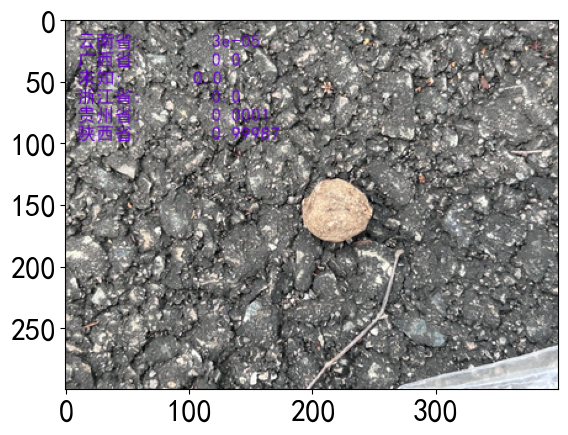

最可能的类别：陕西省
最大分类概率：0.99987
{'0': 3e-05, '1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0001, '5': 0.99987}


In [22]:
#单张图片的预测概率 (可选看)
from PIL import ImageDraw,ImageFont
    
   
import os
font_path = "C:\\Windows\\Fonts\\simhei.ttf"  # 要检查的路径
if os.path.exists(font_path):
        print("路径存在")
else:
        print("路径不存在")
     # 创建一个 ImageFont 对象，设置字体大小
font = ImageFont.truetype(font_path, size=15)


def show_image(img, title=None):
        """展示图像"""
        plt.imshow(img)
        if title:
            plt.title(title)
        #  plt.axis('off')  # 不显示坐标轴
        plt.show()
    # 在predict_函数调用之后，添加如下代码来显示图像 
img = Image.open(r"D:\SanYeQing_Project\sanyeqing_hun_weizhi_finally\test_hun_finally\2496.png")
predicted_class ,max_prob,sorted_class_probs= predict_(img, num_classes=6,
                        model_name=None,
                        model_weight_pth=None,
                        classes=idx_to_labels,
                        model_leibie = None,
                        model_path_zheng=r"D:\SanYeQing_Project\wht_sanyeqing_image-Classification\model_zheng_path\model_cpu_97.18.pth",
                        is_zheng=True
                                            )
    # 创建一个 ImageDraw 对象
draw = ImageDraw.Draw(img)
    # 定义起始位置
start_x = 10
start_y = 10
    # 定义行间距
line_spacing = 15
    # 将字典转换为列表
sorted_class_probs_list = list(sorted_class_probs.items())

    # 遍历字典，将键和值添加到图像上
for key, value in sorted_class_probs_list[:12]:
        key = idx_to_labels[str(key)]
        text = f"{key}:       {value}"
        draw.text((start_x, start_y), text, fill=(100, 0, 200),font=font)
        start_y += line_spacing  # 更新y坐标，以便下一行文本在新的一行
    # 显示图像
show_image(img)  
print(f"最可能的类别：{predicted_class}")
print(f"最大分类概率：{max_prob}")
print(sorted_class_probs)
